In [151]:
# Importacion de librerias 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
import time
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

# 1. Preparación de Datos 

In [152]:
# Cargar datos 

df_car = pd.read_csv('car_data.csv', parse_dates = ['DateCrawled', 'DateCreated', 'LastSeen'], dayfirst=True)

In [153]:
def clean_data(df):
    # Eliminar duplicados
    df = df.drop_duplicates()
    
    # Filtrar años de registro coherentes
    df = df[(df['RegistrationYear'] >= 1900) & (df['RegistrationYear'] <= 2023)]
    
    # Filtrar potencias coherentes
    df = df[(df['Power'] >= 50) & (df['Power'] <= 1000)]
    
    # Eliminar columnas no relevantes
    cols_to_drop = ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures']
    df = df.drop(cols_to_drop, axis=1)

    # Cambio de valores ausentes 
    for col_nul in df.columns[df.isnull().sum() > 0]:
        df.fillna({col_nul:'unknown'}, inplace=True)

    return df


In [154]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [155]:
# Revision de valores ausentes 
df_car.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [156]:
df_car = clean_data(df_car)
df_car.info()

# df_car = df_car.sample(frac=0.01, random_state=42) # Muestra de los datos para acelerar el proceso de entrenamiento en pruebas

<class 'pandas.core.frame.DataFrame'>
Index: 307609 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              307609 non-null  int64 
 1   VehicleType        307609 non-null  object
 2   RegistrationYear   307609 non-null  int64 
 3   Gearbox            307609 non-null  object
 4   Power              307609 non-null  int64 
 5   Model              307609 non-null  object
 6   Mileage            307609 non-null  int64 
 7   RegistrationMonth  307609 non-null  int64 
 8   FuelType           307609 non-null  object
 9   Brand              307609 non-null  object
 10  NotRepaired        307609 non-null  object
dtypes: int64(5), object(6)
memory usage: 28.2+ MB


In [157]:
# Revision de datos en las columnas para los valores ausentes
df_car.isnull().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

In [158]:
df_car.sample(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
134045,3300,bus,1988,manual,57,transporter,125000,6,gasoline,volkswagen,no
206920,16450,sedan,2009,auto,170,cc,125000,2,gasoline,volkswagen,no
333469,650,sedan,2000,manual,102,a3,150000,12,petrol,audi,yes
101679,16000,wagon,2010,manual,178,3er,90000,10,petrol,bmw,no
183582,18500,convertible,2010,auto,306,3er,125000,2,petrol,bmw,no
197044,1200,small,2003,manual,101,ibiza,150000,11,gasoline,seat,yes
69800,4990,coupe,2004,manual,90,one,125000,11,petrol,mini,no
177002,690,small,1998,manual,54,micra,150000,4,petrol,nissan,no
145528,8888,wagon,2009,manual,120,other,150000,4,gasoline,citroen,no
95939,10800,suv,2005,auto,218,grand,150000,6,gasoline,jeep,no


In [159]:
df_car.shape

(307609, 11)

# Entrenamiento de modelos 

In [160]:
# Division de datos de entrenamiento y prueba 

X = df_car.drop(columns='Price')
y = df_car['Price'] 

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 123)

In [161]:
# Preprocesamiento para los modelos que requieren OHE
numeric_cols = X.select_dtypes(include=['int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_cols),
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    remainder='passthrough'
)

## Modelos

In [162]:
# Modelos tradicionales
traditional_models = {
    'Linear Regression' : LinearRegression(),
    'Decision Tree' : DecisionTreeRegressor(random_state = 123),
    'Random Forest' : RandomForestRegressor(random_state = 123, n_jobs = -1)
}

# Modelos con boosting
boosting_models = { 
    'LightGBM' : lgb.LGBMRegressor(random_state=123, verbosity = -1),
    'CatBoost' : CatBoostRegressor(random_state = 123, silent = True, cat_features = categorical_cols.tolist()),
    'XGBoost' : XGBRegressor(random_state=123)
}

In [163]:
# Hiperparametros para GridSearch
param_grid = {
    'Random Forest' : {
        'randomforestregressor__n_estimators' : [100, 150],
        'randomforestregressor__max_depth' : [None, 20], 
        'randomforestregressor__min_samples_split' : [2,5]
    },
    'LightGBM' : {
        'lgbmregressor__learning_rate' : [0.1, 0.05],
        'lgbmregressor__n_estimators' : [100, 150], 
        'lgbmregressor__num_leaves' : [31, 63]
    }, 
    'CatBoost' : {
        'catboostregressor__iterations' : [100, 150],
        'catboostregressor__depth' : [6, 8],
        'catboostregressor__learning_rate' : [0.1, 0.05]
    }, 
    'XGBoost' : {
        'xgbregressor__learning_rate' : [0.1, 0.05],
        'xgbregressor__n_estimators' : [100, 150], 
        'xgbregressor__max_depth' : [3, 6] 
    }
}

## Evaluacion de modelos

In [ ]:
# Funcion para evaluar modelos tradicionales

def evaluate_traditional_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    start_train = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = pipeline.predict(X_test)
    pred_time = time.time() - start_pred

    rmse = root_mean_squared_error(y_test, y_pred)

    return rmse, train_time, pred_time

## Entrenamiento de Modelos

In [ ]:
results = []

# Modelos Tradicionales
for name, model in traditional_models.items():
    print(f'Entrenando {name}...')

    try: 
        rmse, train_time, pred_time = evaluate_traditional_model(model, X_train, X_test, y_train, y_test)
        results.append({
            'Model' : name,
            'RMSE' : rmse, 
            'Train Time (s)' : train_time,
            'Prediction Time (s)' : pred_time
        })
    except Exception as e: 
        print(f'Error con {name}: {str(e)}')

Entrenando Linear Regression...
Entrenando Decision Tree...
Entrenando Random Forest...


In [166]:
# Ajuste de hiperparametros 

for name in param_grid.keys(): 
    print(f'Ajustando {name}')

    try: 
        if name == 'Random Forest':
            hy_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                (list(param_grid[name].keys())[0].split('_')[0], traditional_models[name])
            ])
        else: 
            hy_pipeline = Pipeline([
                ('preprocessor', preprocessor),
                (list(param_grid[name].keys())[0].split('_')[0], boosting_models[name])
            ])
        
        grid_search = GridSearchCV(
            hy_pipeline, 
            param_grid[name],
            cv = 3,
            scoring = 'neg_root_mean_squared_error',
            n_jobs = -1
        )

        if name in 'LightGBM':
            X_train_lgb = X_train.copy()
            X_test_lgb = X_test.copy()
            for col in categorical_cols:
                X_train_lgb[col] = X_train_lgb[col].astype('category')
                X_test_lgb[col] = X_test_lgb[col].astype('category')
            
            start_train = time.time()
            grid_search.fit(X_train_lgb, y_train)
            train_time = time.time() - start_train

            start_pred = time.time()
            y_pred = grid_search.predict(X_test_lgb)
            pred_time = time.time() - start_pred

            rmse = root_mean_squared_error(y_test, y_pred)

        elif name == 'CatBoost':
            cat_pipeline = Pipeline([
                    ('preprocessor', preprocessor),
                    ('catboostregressor', CatBoostRegressor(random_state = 123, silent = True))
                ])
            
            grid_search = GridSearchCV(
                cat_pipeline,
                param_grid['CatBoost'],
                cv=3,
                scoring='neg_root_mean_squared_error',
                n_jobs=-1
            )

            start_train = time.time()
            grid_search.fit(X_train, y_train)
            train_time = time.time() - start_train

            start_pred = time.time()
            y_pred = grid_search.predict(X_test)
            pred_time = time.time() - start_pred

            rmse = root_mean_squared_error(y_test, y_pred)
                        
        else: 
            start_train = time.time()
            grid_search.fit(X_train, y_train)
            train_time = time.time() - start_train

            start_pred = time.time()
            y_pred = grid_search.predict(X_test)
            pred_time = time.time() - start_pred

            rmse = root_mean_squared_error(y_test, y_pred)
            
        results.append({
            'Model': f'{name} (Ajustado)',
            'RMSE': rmse,
            'Train Time (s)': train_time,
            'Prediction Time (s)': pred_time
        })
        
    except Exception as e:
        print(f"Error ajustando {name}: {str(e)}")

Ajustando Random Forest
Ajustando LightGBM


C:\Users\lloyd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Ajustando CatBoost
Ajustando XGBoost


In [172]:
results_df = pd.DataFrame(results).sort_values(by = 'RMSE')
results_df.reset_index(drop=True, inplace=True)


Final Results:
                      Model         RMSE  Train Time (s)  Prediction Time (s)
0  Random Forest (Ajustado)  1675.999737     8081.063189             1.123191
1             Random Forest  1697.398810      783.230787             0.806243
2       LightGBM (Ajustado)  1704.123435       23.521119             0.717267
3        XGBoost (Ajustado)  1775.029419       12.781644             0.280061
4       CatBoost (Ajustado)  1796.784720       31.586106             0.336155
5             Decision Tree  2172.527032       67.538165             0.176314
6         Linear Regression  2653.633299        1.698735             0.115663


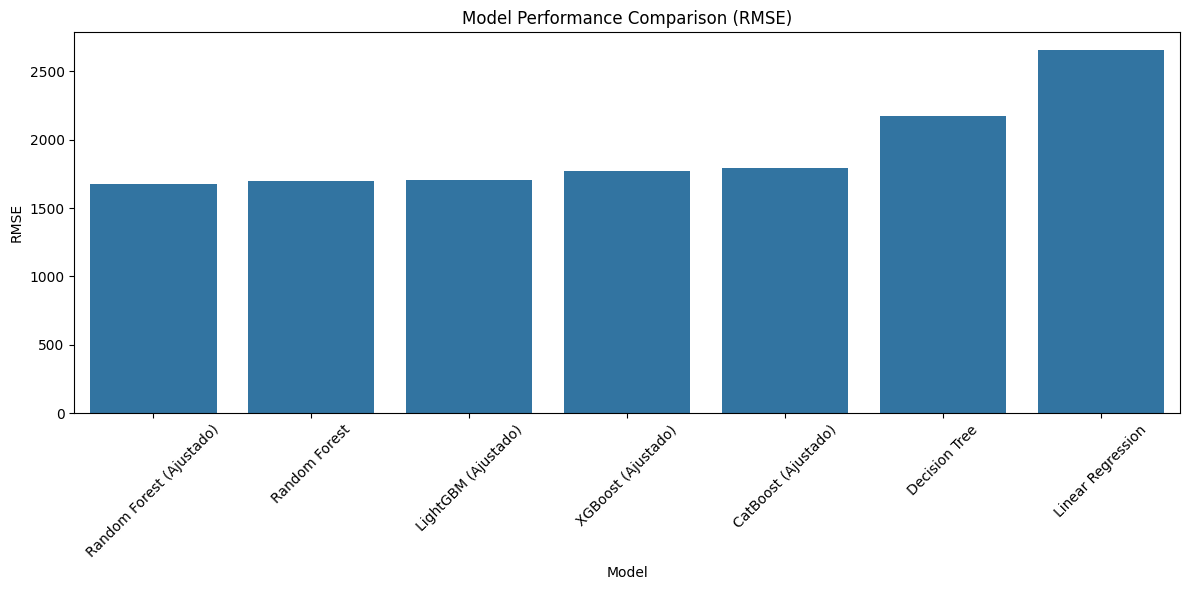


Best model: Random Forest (Ajustado)


In [171]:
# 6. Results Analysis
print("\nFinal Results:")
print(results_df[['Model', 'RMSE', 'Train Time (s)', 'Prediction Time (s)']].to_string())

# Visualize results
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x='Model', y='RMSE')
plt.xticks(rotation=45)
plt.title('Model Performance Comparison (RMSE)')
plt.tight_layout()
plt.show()

# Save best model
best_model_name = results_df.iloc[0]['Model']
print(f"\nBest model: {best_model_name}")

# Conlclusion

1. **Mejor Modelo con Precisión (RMSE):**
* **Random Forest Ajustado** obtuvo el menor RMSE (1675.99), este fue el mas preciso. Sin embargo, su tiempo de entrenamiento fue extemadamente alto (8081.06 s) lo que lo hace poco practico para entornos donde la velocidad es critica.

2. **Equilibrio entre Precisión y Velocidad:**
* **LightGBM** ofrece un buen equilibrio entre el RMSE junto con la velocidad de entrenamiento. Este tiene un RMSE de (1704.12, lo cual es solamente 1.7% mas alto que Random Forest). Asimismo, tiene un tiempo de entrenamiento 350 veces mas rapido que el Random Forest Ajustado con 23.5s. 

3. **Modelo Más Rápido en Entrenamiento:**
* **XGBoost** fue el mas rapido en entrenarse con (12.8s) con un RMSE de 1775. Este podria ser ideal para hacer iteraciones rapidas durante el desarrollo. 

5. **Tiempos de Predicción:**
* Todos los modelos a excepción de Random Forest predicen en < 1s, siendo XGBoost el mas rapido (0.28s). Esto es crucial para las aplicaciones en tiempo real. 



Precisión (RMSE) vs. Velocidad de Entrenamiento:
|RMSE |Modelo                      |Velocidad|
|-----|----------------------------|---------|
|1676 | ● Random Forest (Ajustado) |[Lento]  |
|1704 | ● LightGBM           |[Recomendado]  |
|1775 | ● XGBoost             |[Más Rápido]  |

En conclusión el mejor modelo para utilizar en esta aplicación seria **LightGBM** ya que ofrece un balance óptimo entre la precisión y velocidad de entrenamiento para este caso de uso. 